In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import operator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]#, 85, 135, 192]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]
NUM_TEST = 10
LIM = 5
MUL = 10

In [3]:
def compute_diagram(points, k=3):
    r = np.max(pdist(points, 'euclidean'))
    f = d.fill_rips(points, k, r)
    m = d.homology_persistence(f)
    return d.init_diagrams(m, f)

def get_max_diag_dim(dgms, h=1):
    m = 0
    for d in dgms:
        n = len(d[h])
        if n > m:
            m = n
    return m


def compute_sample_weights(y, lim=LIM, mul=MUL, up_lim=None, up_mul=None):
    ret = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        v = y[i]
        if v < lim:
            ret[i] = np.abs(lim-v)*mul
        if up_lim is not None:
            if v > up_lim:
                if up_mul is not None:
                    ret[i] = np.abs(lim-v)*up_mul
                else:
                    ret[i] = np.abs(lim-v)*mul
    return ret

def create_train_test_matrices(train_keys, test_keys):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x6_test = create_x6_matrix(L_test, max_dims=x6_dims)
    x7_test = create_x7_matrix(L_test, max_dims=x7_dims)
    
    x40_x47_train = excel_train.iloc[:, 3:-2]
    master_train, master_names = prepare_master(x40_x47_train)
    
    x40_x47_test = excel_test.iloc[:, 3:-2]
    master_test, master_names = prepare_master(x40_x47_test)
    
    X_train = np.hstack((x4_train,x4_train,x5_train,x6_train,x7_train))
    X_test = np.hstack((x4_test, x4_test, x5_test, x6_test, x7_test))
    
    X = np.vstack((X_train,X_test))
    K = rbf_kernel(X)
    X_train = K[:len(y_train), :len(y_train)]
    X_test = K[len(y_train):, :len(y_train)]
    
    return (X_train, y_train), (X_test, y_test)

def create_train_test_diagram_kernels_x4(train_keys, test_keys, h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    print('Computing Training Diagrams')
    diags_train = []
    for l in L_train:
        diags_train.append(compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values))
    for i in range(len(diags_train)):
        if len(diags_train[i][h]) == 0:
            diags_train[i] = np.array([[0,0]])
        else:
            diags_train[i] = np.array([[pt.birth,pt.death] for pt in diags_train[i][h]])
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_train + diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    
    D_train = D[:len(y_train), :len(y_train)]
    D_test = D[len(y_train):, :len(y_train)]
    return (D_train, y_train), (D_test, y_test)
      
    
def create_test_diagram_kernels(h=1, num_directions=1, bandwidth=1.0, x_type='x1', exclude_keys=EXCLUDE_KEYS):
    excel = parse_master_file(exclude_keys=exclude_keys)
    excel_test = excel
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    print('Computing Test Diagrams')
    diags_test = []
    if x_type == 'x1':
        for l in L_test:
                diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    if x_type == 'x4':
        for l in L_test:
            diags_test.append(compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values))
    if x_type == 'x5':
        for l in L_test:
            diags_test.append(compute_diagram(parse_x5(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=num_directions, bandwidth=bandwidth)
    
    D = SW.fit_transform(dd)
    
    return (D, y_test)

def get_diag(k, h=1): 
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    l = get_filename_list(excel[excel['Key'] == k]['Associated data'])[0]
    dgm = compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values)
    return dgm

def remove_for_loo(D, i, kernel=True):
    if kernel:
        D_train = np.delete(np.delete(D, i, axis=0), i, axis=1)
        D_test = np.delete(D[i], i, axis=0).reshape(1,-1)
    else:
        D_train = np.delete(D,i,axis=0)
        D_test = D[i].reshape(1,-1)
    return D_train, D_test

def create_classes(y, lims):
    classes = []
    for s in y:
        if s <= lims[0]:
            classes.append(0)
        elif s > lims[-1]:
            classes.append(len(lims)+1)
        else:
            for i in range(len(lims)-1):
                if s > lims[i] and s <= lims[i+1]:
                    classes.append(i+1)
                    break
    return pd.DataFrame(classes)

def create_class_boundaries(df, lims):
    predicted_classes = []
    actual_classes = []
    for idx, row in df.iterrows():
        if row['actual'] <= lims[0]:
            actual_classes.append(0)
        elif row['actual'] > lims[-1]:
            actual_classes.append(len(lims)+1)
        else:
            for i in range(len(lims)-1):
                if row['actual'] > lims[i] and row['actual'] <= lims[i+1]:
                    actual_classes.append(i+1)
                    break
    for idx, row in df.iterrows():
        if row['predicted'] <= lims[0]:
            predicted_classes.append(0)
        elif row['predicted'] > lims[-1]:
            predicted_classes.append(len(lims)+1)
        else:
            for i in range(len(lims)-1):
                if row['predicted'] > lims[i] and row['predicted'] <= lims[i+1]:
                    predicted_classes.append(i+1)
                    break
 

    print(len(actual_classes), len(predicted_classes))
    return pd.DataFrame({'actual_class': actual_classes, 'predicted_class': predicted_classes})


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title)
    plt.xlabel('Experimental logK', fontweight='bold')
    plt.ylabel('Predicted logK', fontweight='bold')
    plt.tick_params(direction='in')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
   

In [4]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index(drop=True)
keys = list(excel['Key'])
L = get_filename_list(excel['Associated data'])

[3, 9]


In [5]:
x10_x17 = excel.iloc[:, 3:-3]
x10_x17.head()

,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI #,X17: CI
0,A,298.0,0,0,0,7.00,0,N
1,B,298.0,0,0,50,4.74,0,N
2,A,298.0,0,0,0,7.00,1,CI_2
3,A,298.0,0,0,0,7.00,2,CI_1
4,A,298.0,0,0,0,7.00,2,CI_2


In [6]:
master, master_names = prepare_master(x10_x17)

In [7]:
train_set_x1 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x1')
train_set_x4 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x4')
train_set_x5 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x5')
X1 = train_set_x1[0]
X4 = train_set_x4[0]
X5 = train_set_x5[0]

D_test_x1 = np.delete(X1[191:193], [191,192], axis=1)
D_test_x4 = np.delete(X4[191:193], [191,192], axis=1)
D_test_x5 = np.delete(X5[191:193], [191,192], axis=1)

D_train_x1 = np.delete(np.delete(X1, [191,192], axis=0), [191,192], axis=1)
D_train_x4 = np.delete(np.delete(X4, [191,192], axis=0), [191,192], axis=1)
D_train_x5 = np.delete(np.delete(X5, [191,192], axis=0), [191,192], axis=1)

y = train_set_x1[1]
y_test = y[191:193]
y_train = np.delete(y, [191,192], axis=0)
        
        
K = master
K = rbf_kernel(K, gamma=0.0001)
K_test = np.delete(K[191:193], [191,192], axis=1)
K_train = np.delete(np.delete(K, [191,192], axis=0), [191,192], axis=1)

X3 = create_x3_matrix(L)
X3 = laplacian_kernel(X3, gamma=0.0001)
D_test_x3 = np.delete(X3[191:193], [191,192], axis=1)
D_train_x3 = np.delete(np.delete(X3, [191,192], axis=0), [191,192], axis=1)

X5b = create_x5_matrix(L)[:,0].reshape(-1,1)
X5b = rbf_kernel(X5b, gamma=0.0001)
D_test_x5b = np.delete(X5b[191:193], [191,192], axis=1)
D_train_x5b = np.delete(np.delete(X5b, [191,192], axis=0), [191,192], axis=1)

X6 = create_x6_matrix(L, max_dims=(50, 6))
X6 = laplacian_kernel(X6, gamma=0.0001)
D_test_x6 = np.delete(X6[191:193], [191,192], axis=1)
D_train_x6 = np.delete(np.delete(X6, [191,192], axis=0), [191,192], axis=1)

X7 = create_x7_matrix(L)
X7 = rbf_kernel(X7, gamma=0.0001)
D_test_x7 = np.delete(X7[191:193], [191,192], axis=1)
D_train_x7 = np.delete(np.delete(X7, [191,192], axis=0), [191,192], axis=1)      

[3, 9]
Computing Test Diagrams
Computing Kernel
[3, 9]
Computing Test Diagrams
Computing Kernel
[3, 9]
Computing Test Diagrams
Computing Kernel
50 50


In [8]:
class_limits = [2, 4, 6, 8, 10, 12]
class_names = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12+']

In [9]:
alls = [X1, X3, X4, X5, X5b, X6, X7, K]
trains = [D_train_x1,D_train_x3,D_train_x4,D_train_x5,D_train_x5b,D_train_x6,D_train_x7,K_train]
tests = [D_test_x1,D_test_x3,D_test_x4,D_test_x5,D_test_x5b,D_test_x6,D_test_x7,K_test]
x_names = ['x1', 'x3', 'x4', 'x5', 'x5b', 'x6', 'x7', 'X10-X17']

196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196


/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196
196 196


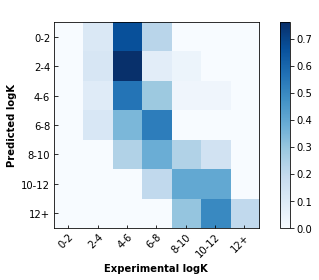

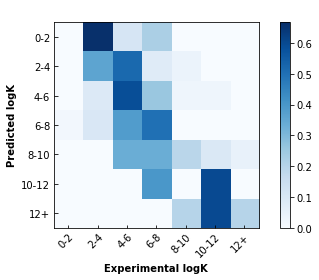

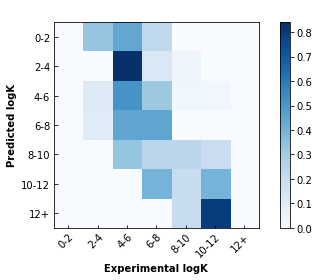

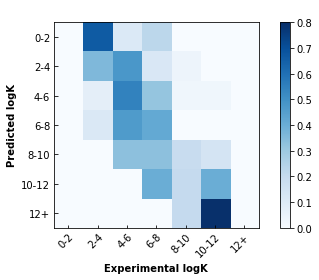

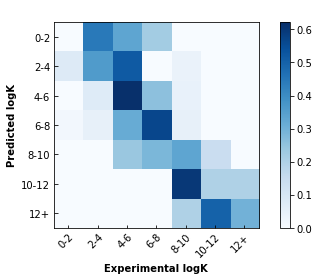

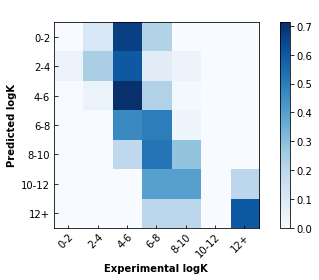

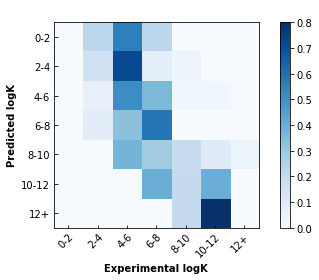

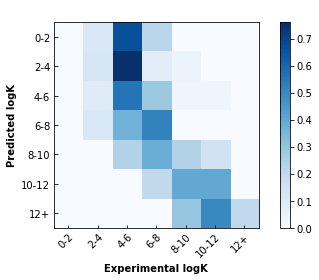

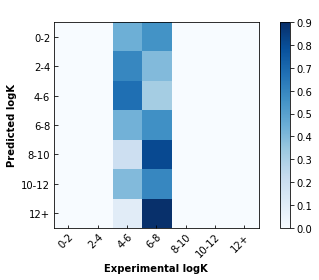

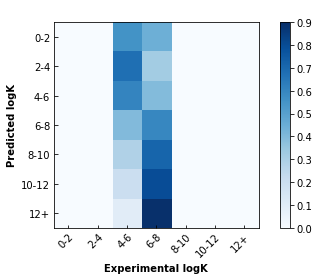

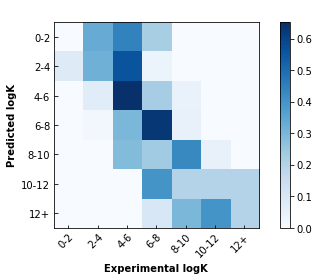

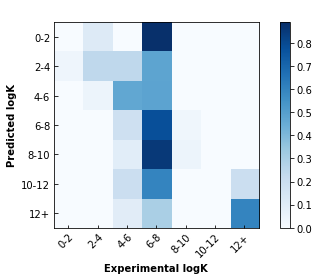

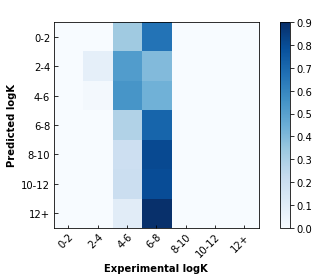

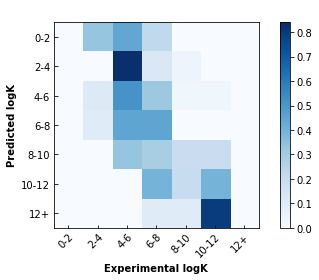

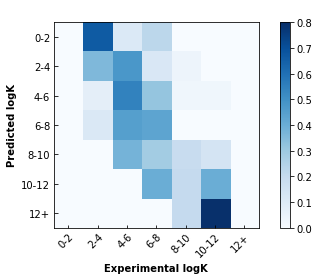

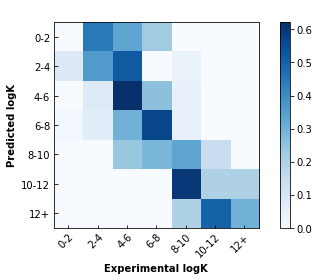

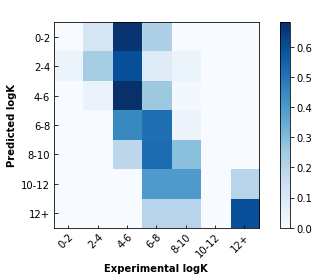

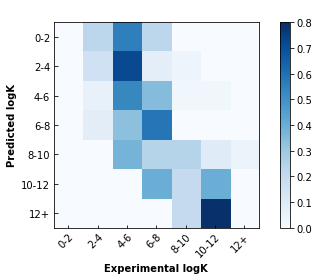

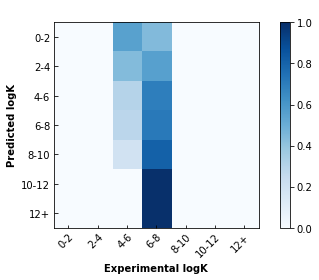

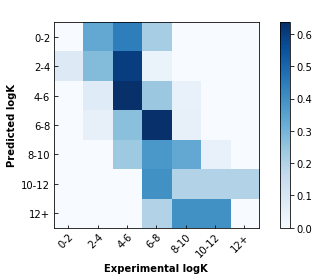

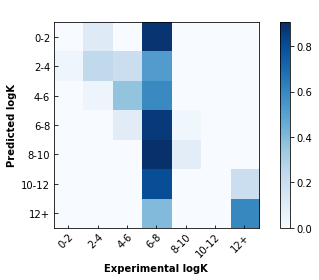

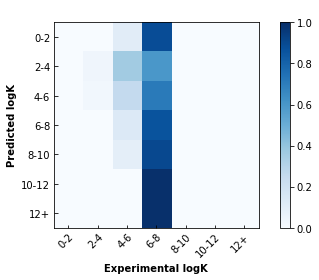

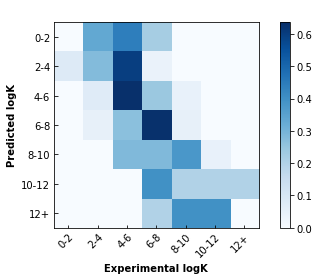

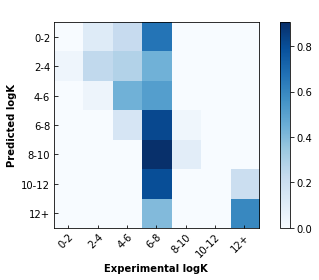

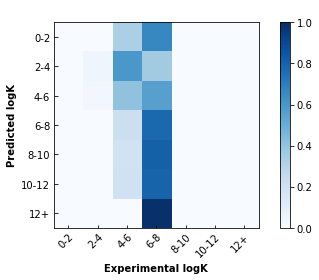

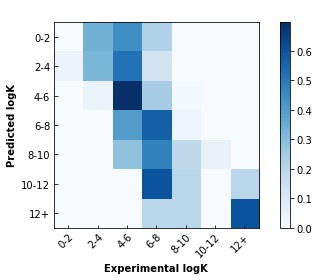

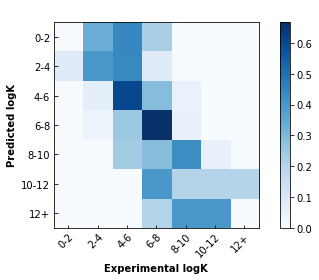

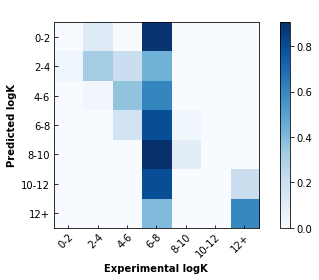

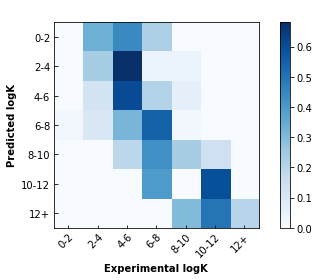

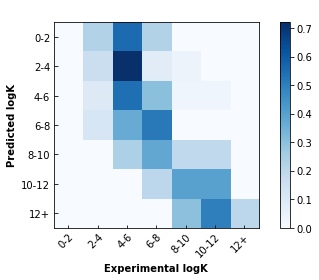

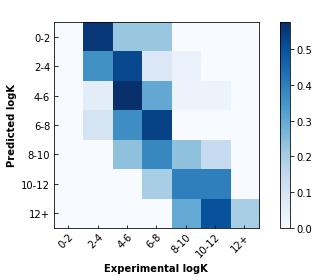

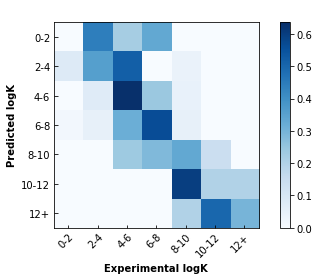

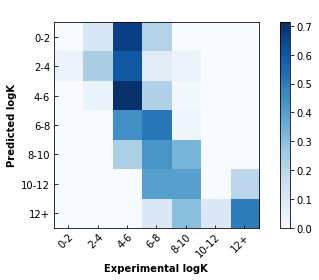

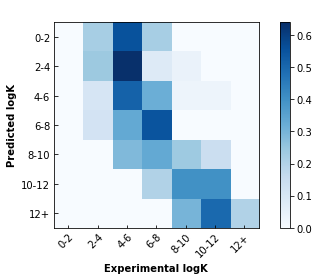

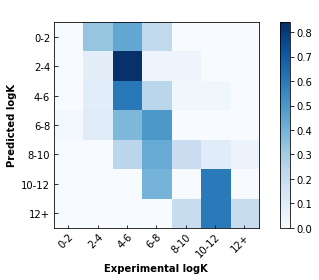

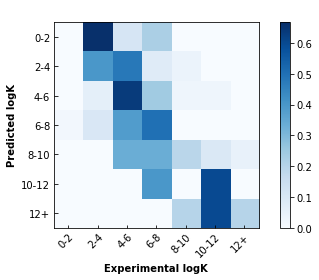

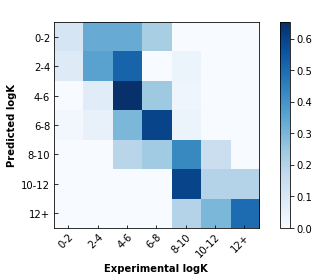

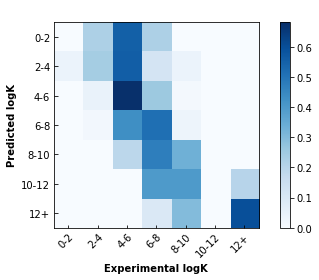

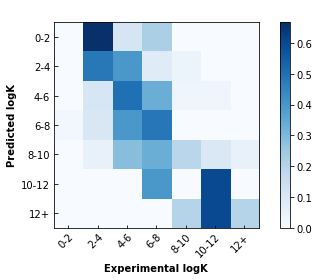

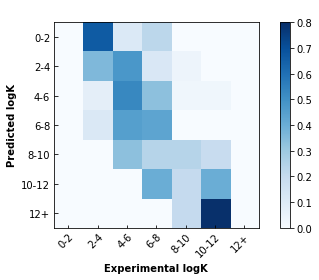

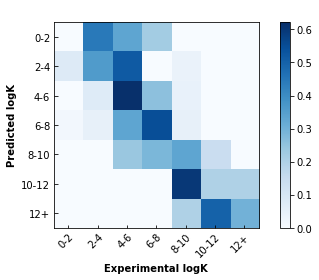

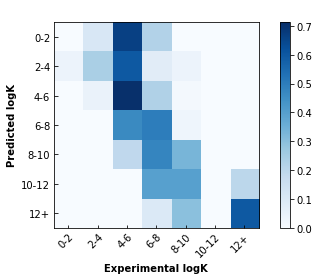

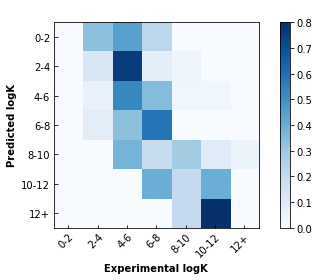

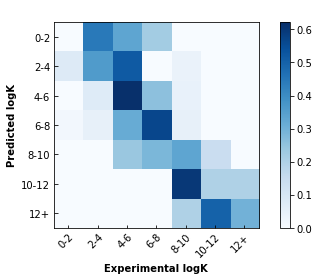

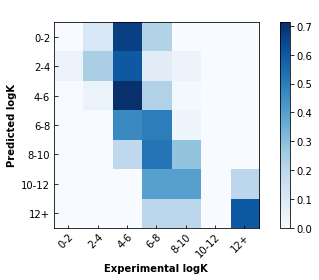

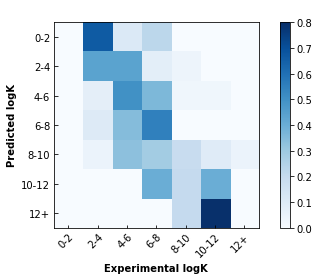

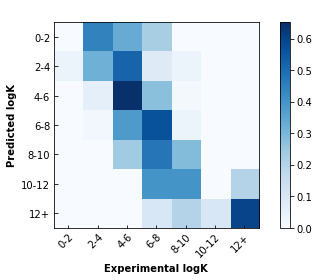

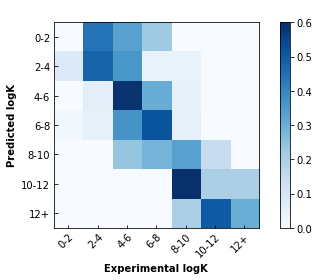

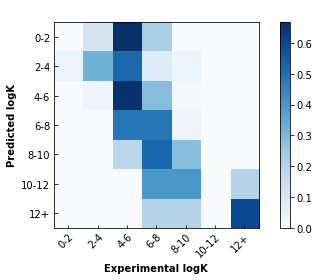

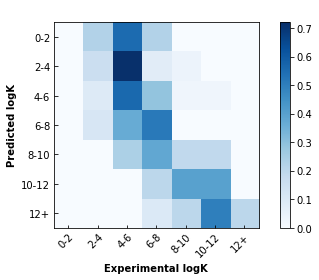

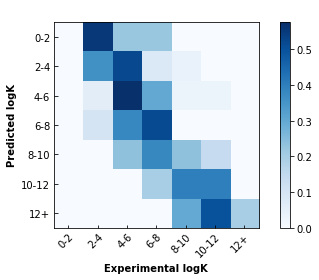

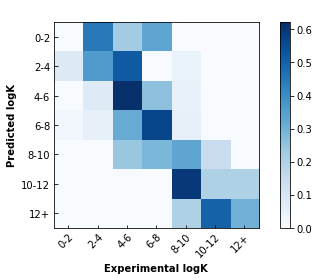

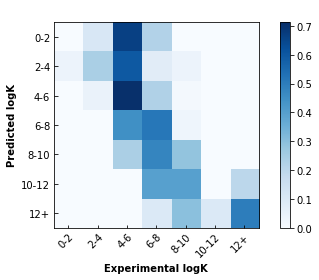

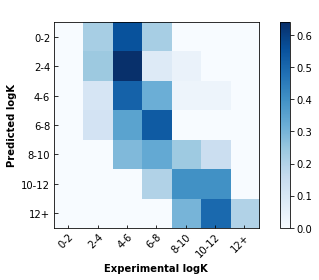

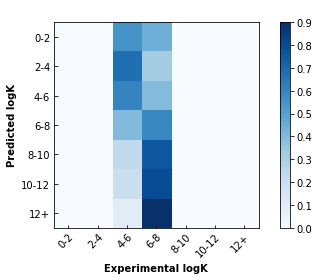

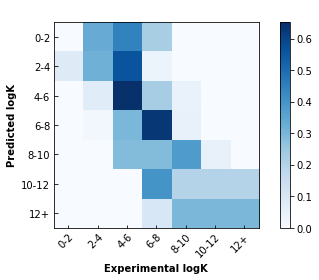

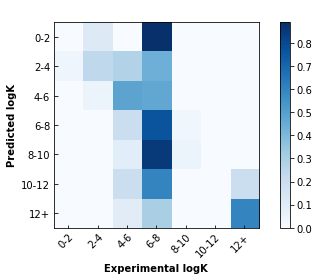

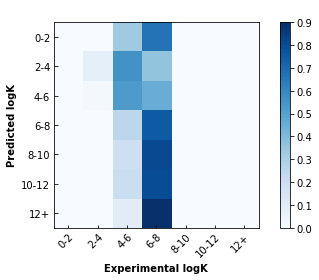

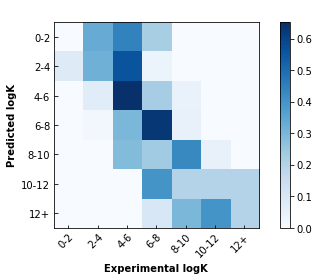

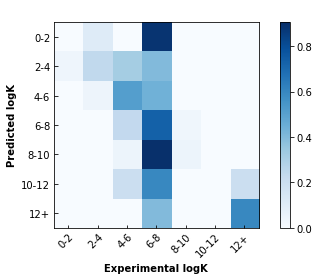

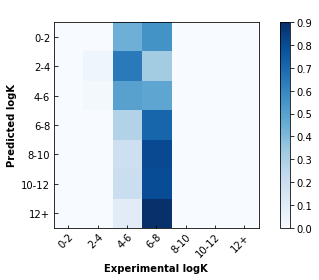

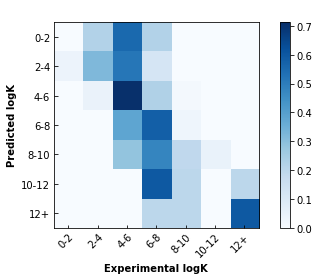

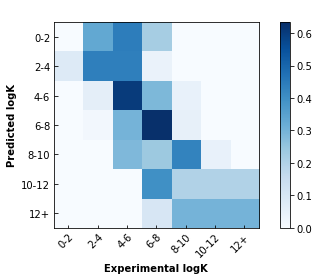

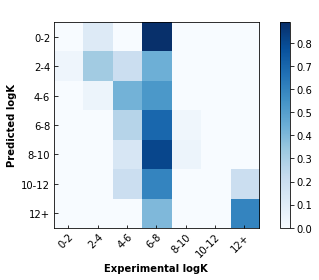

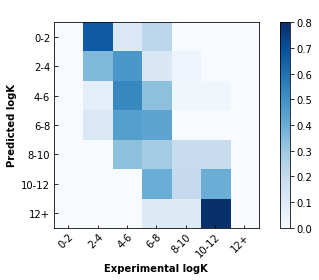

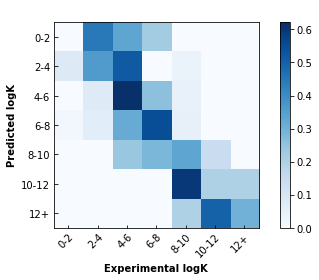

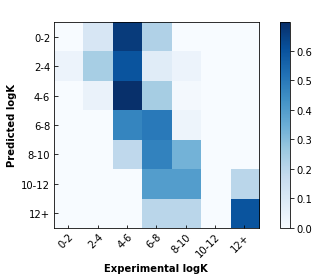

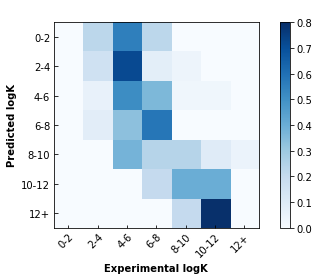

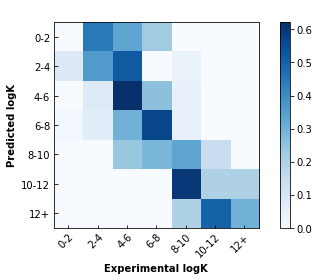

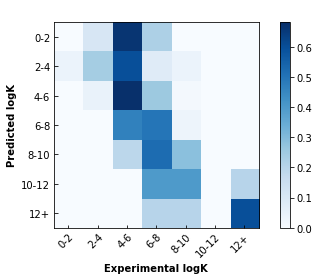

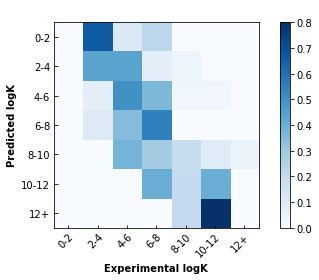

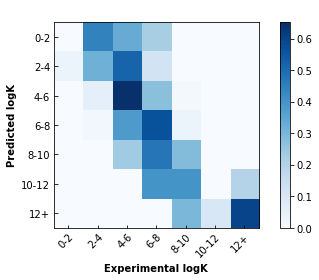

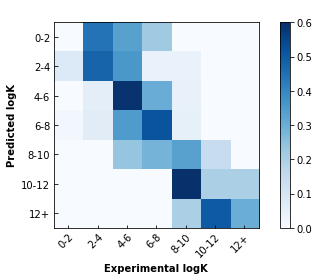

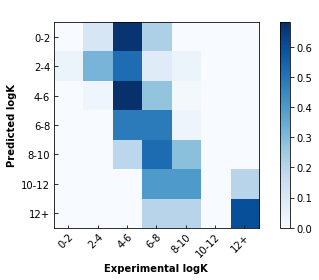

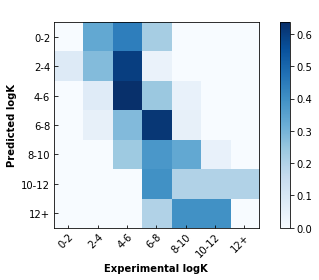

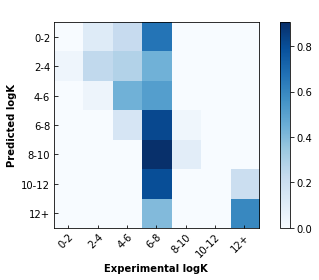

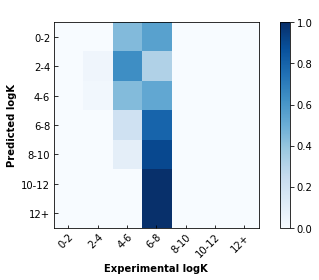

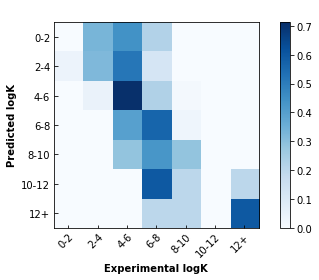

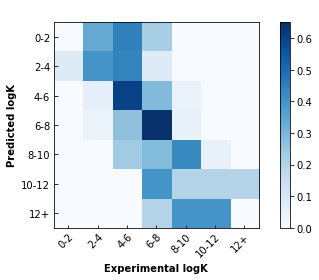

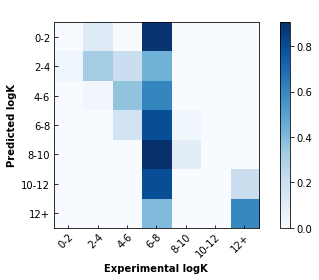

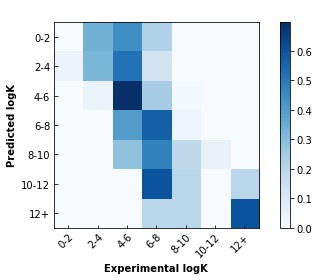

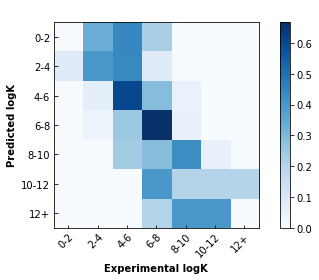

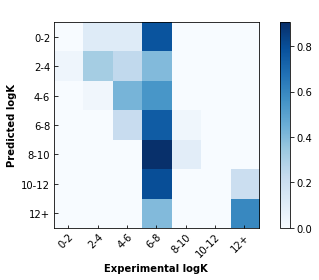

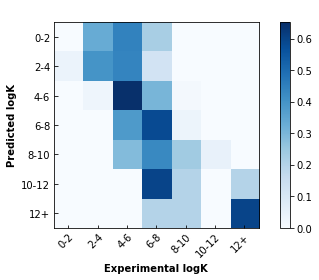

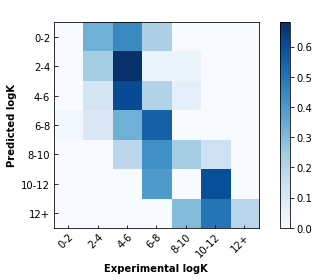

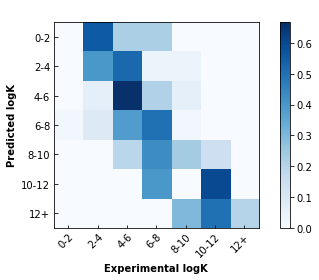

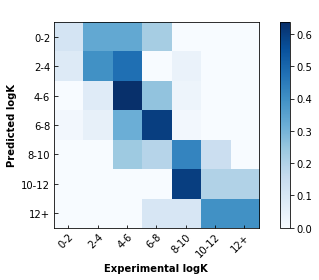

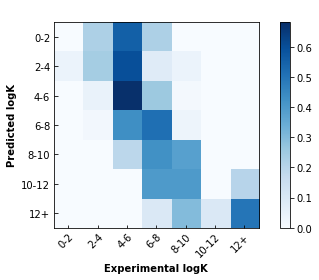

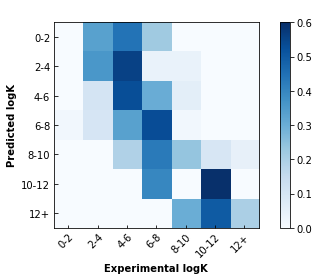

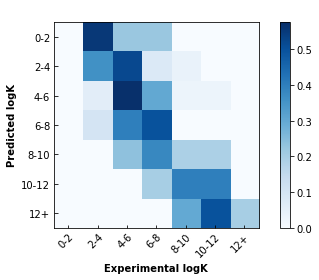

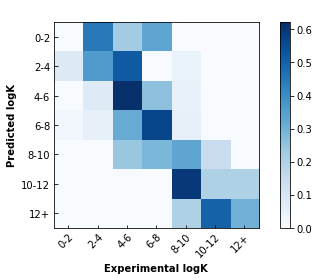

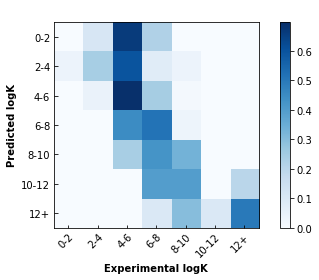

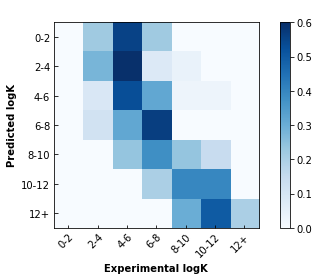

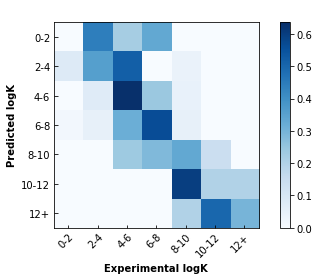

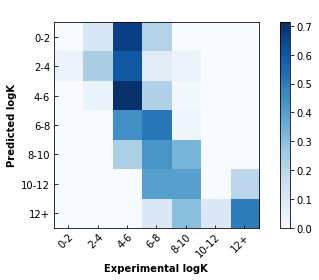

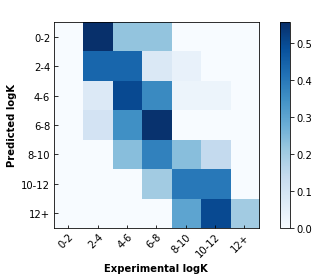

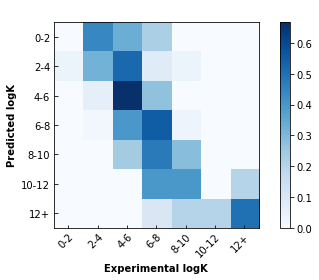

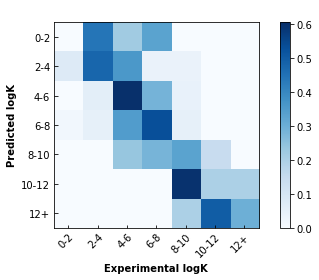

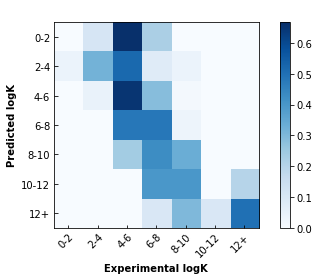

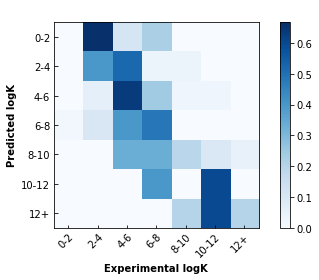

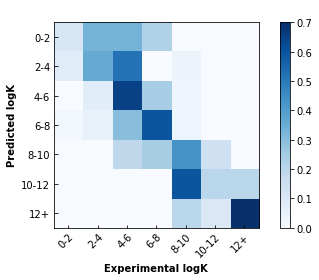

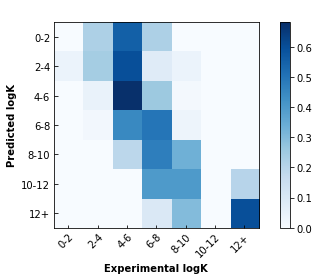

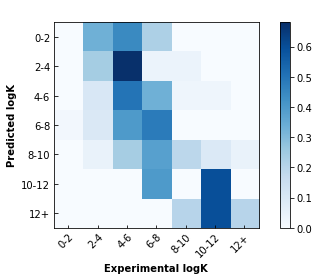

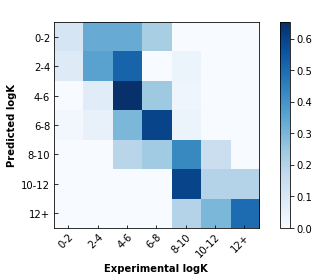

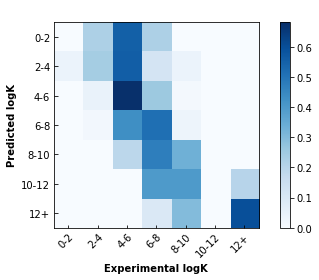

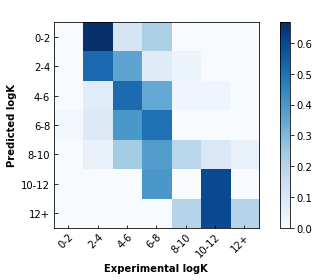

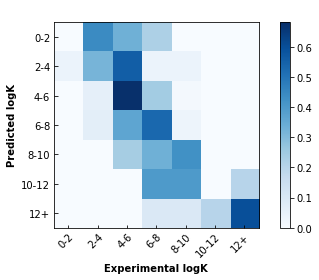

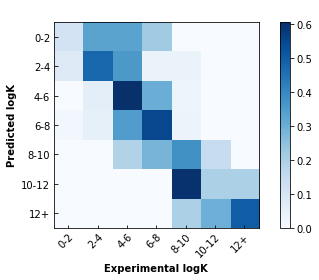

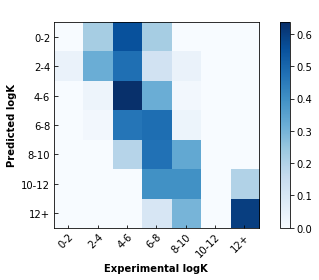

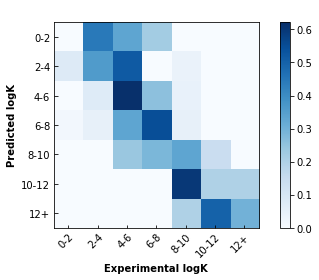

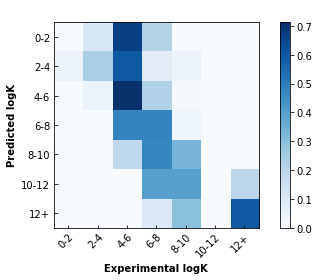

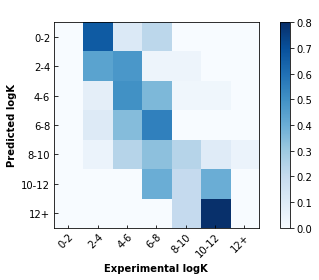

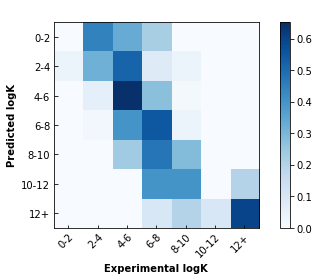

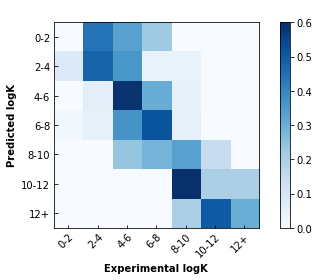

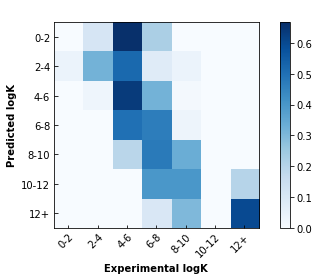

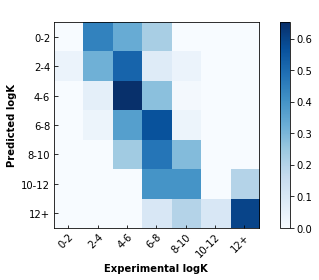

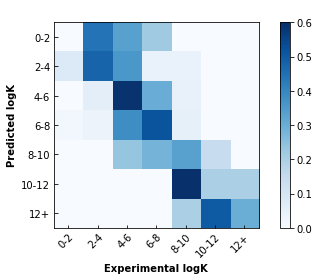

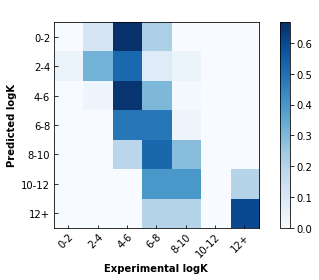

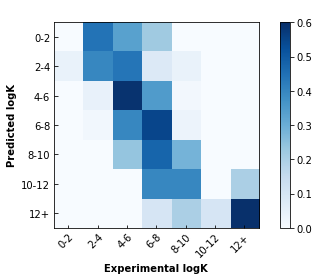

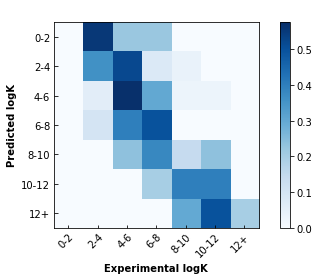

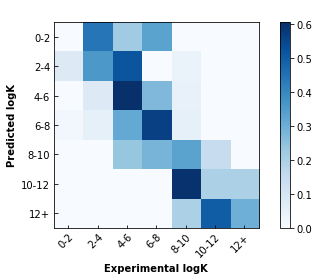

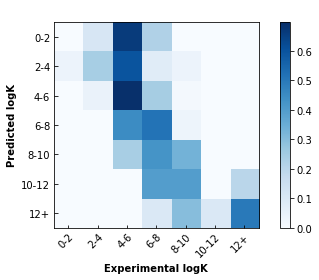

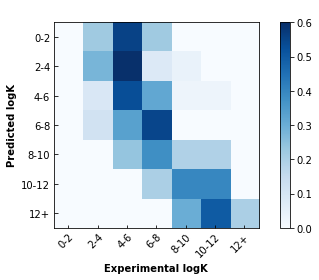

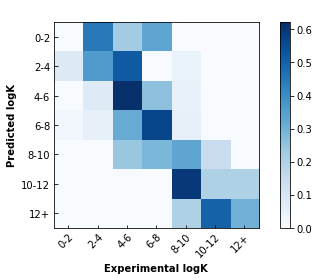

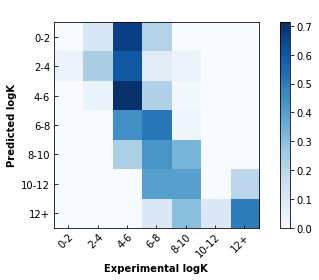

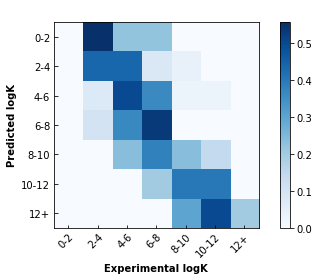

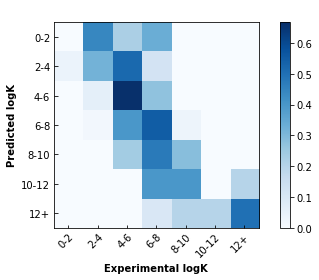

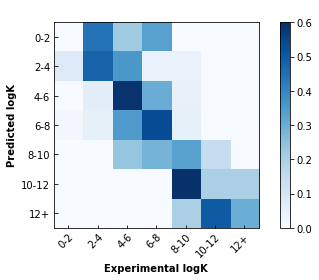

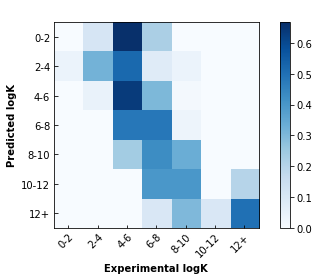

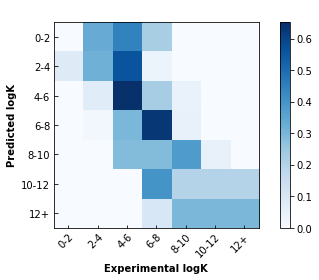

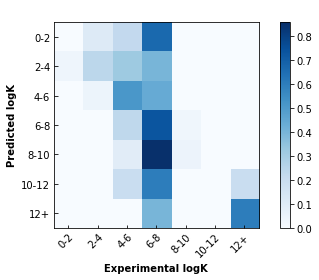

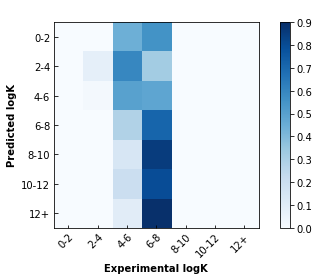

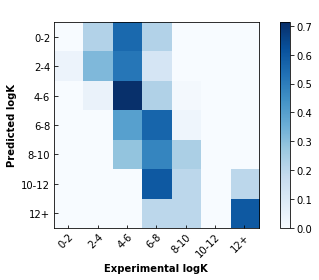

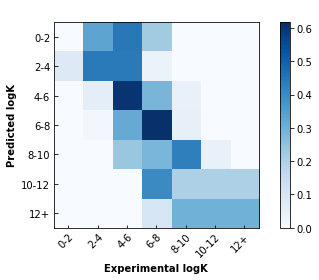

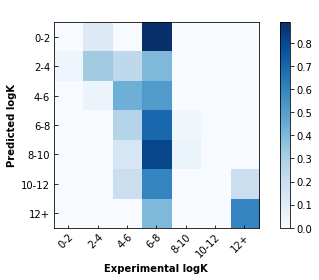

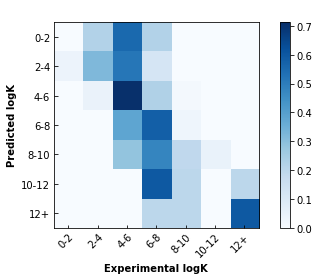

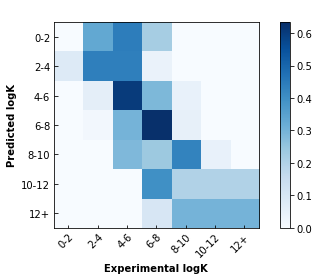

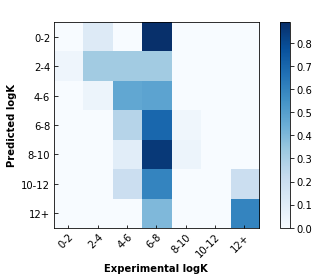

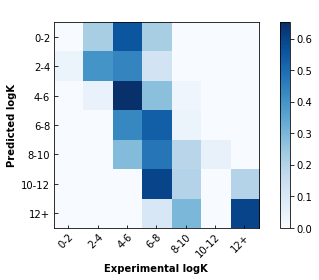

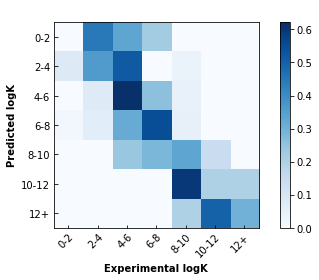

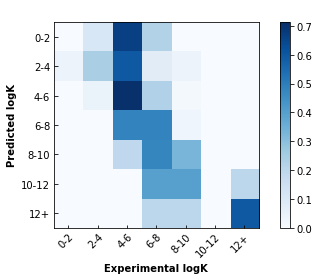

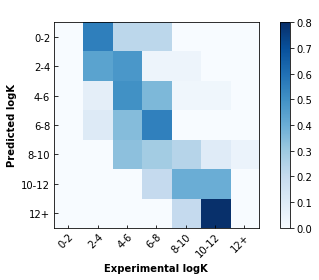

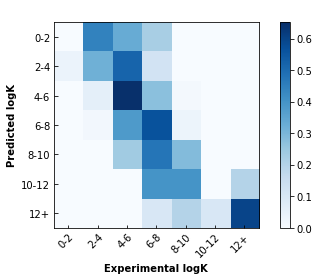

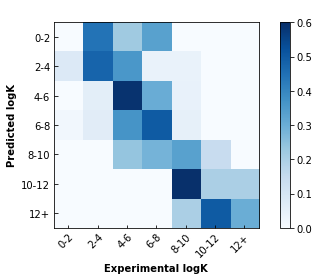

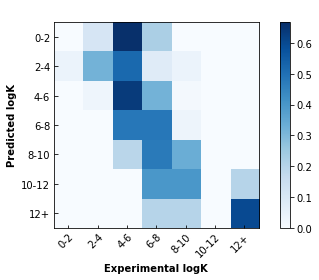

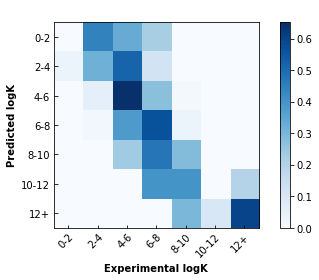

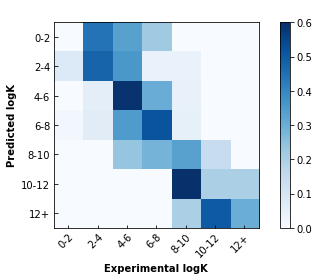

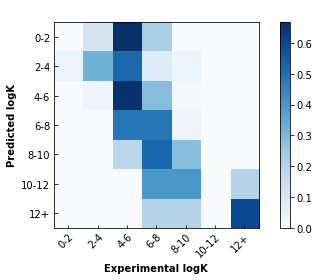

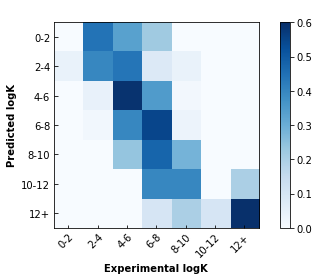

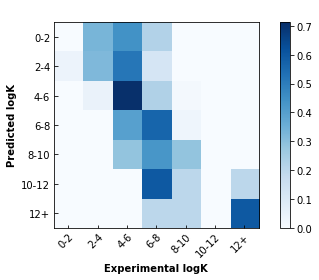

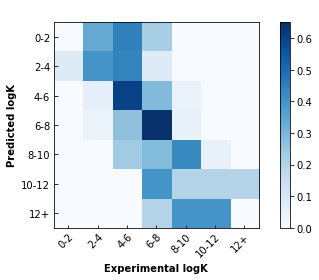

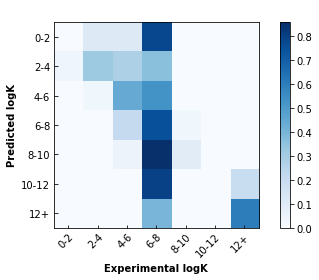

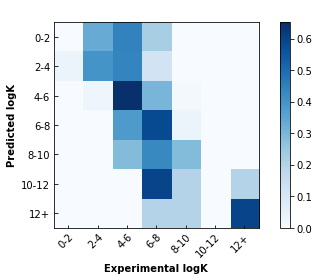

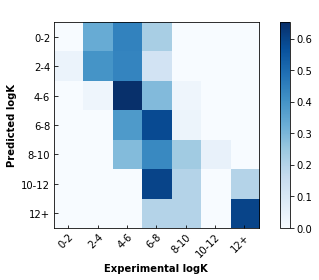

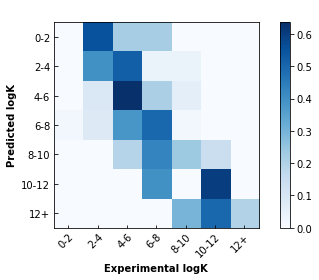

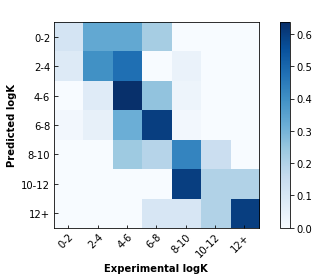

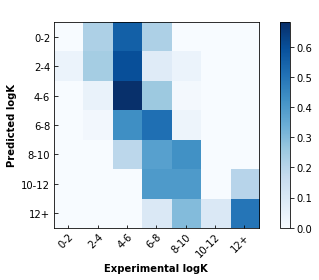

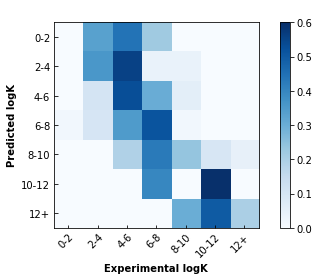

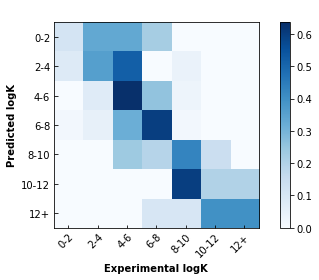

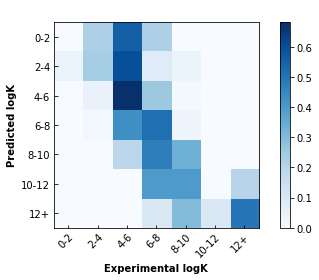

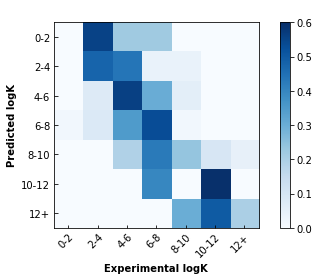

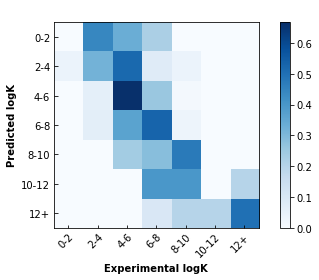

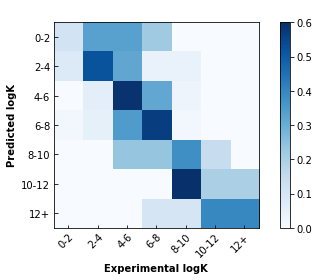

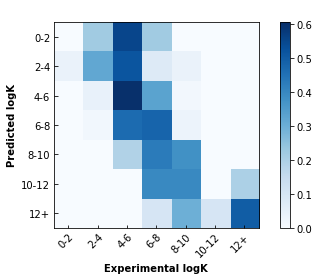

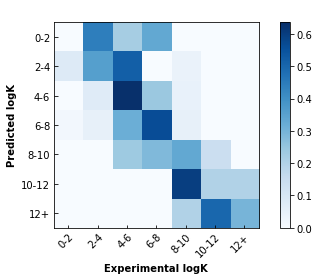

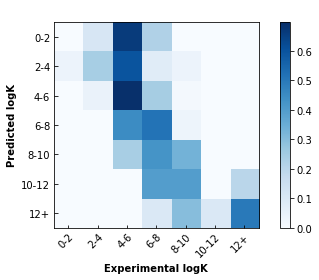

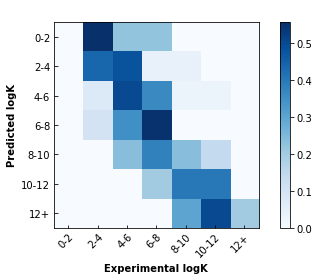

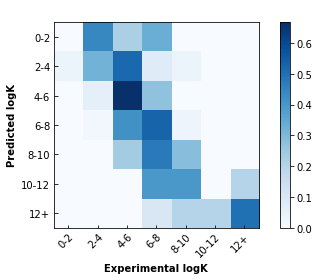

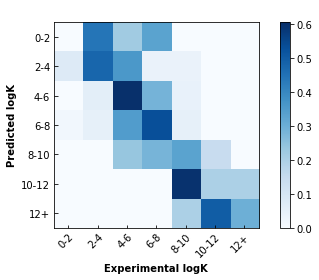

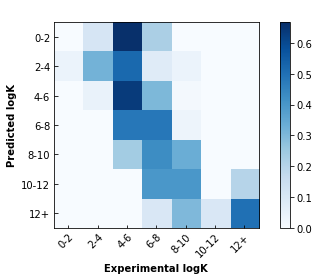

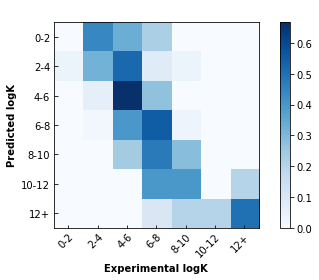

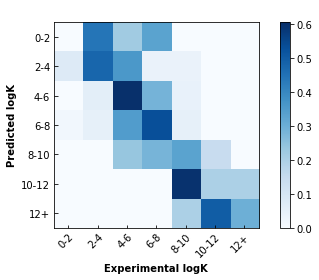

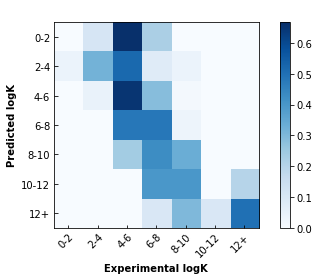

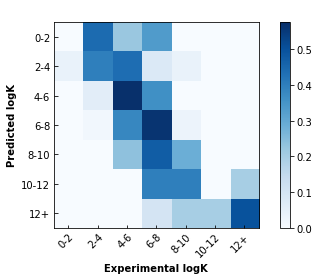

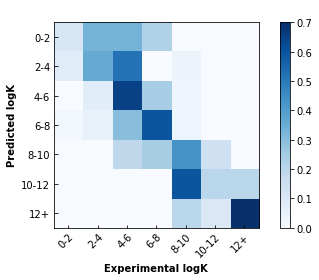

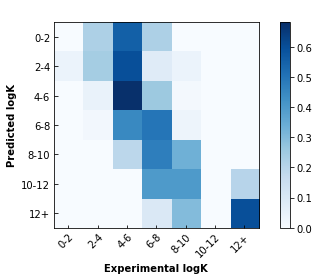

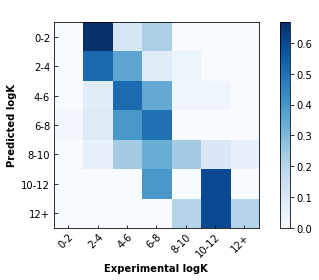

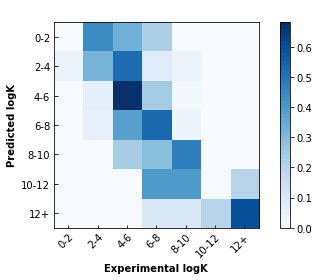

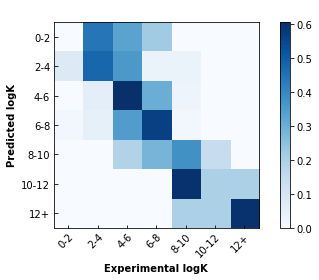

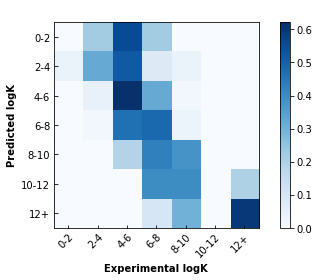

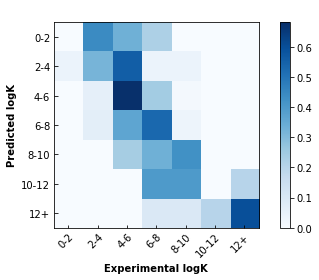

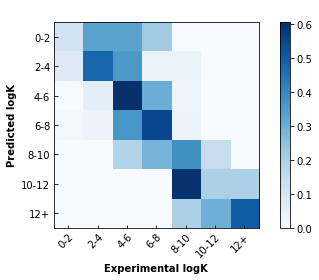

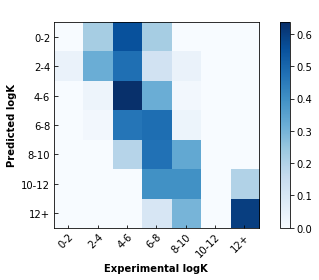

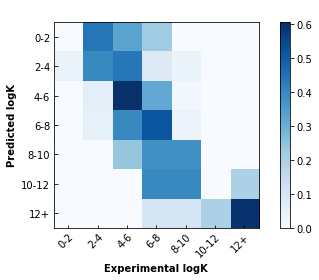

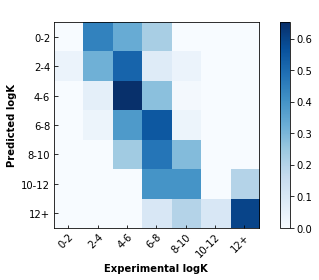

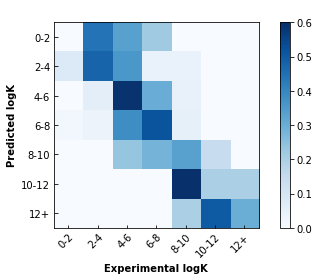

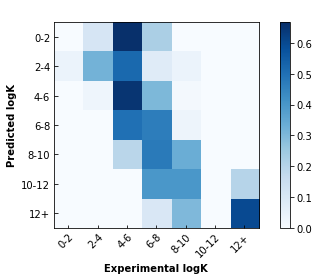

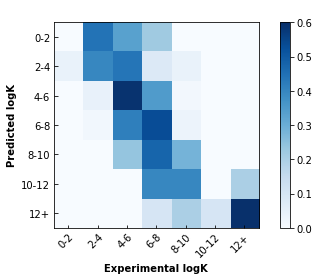

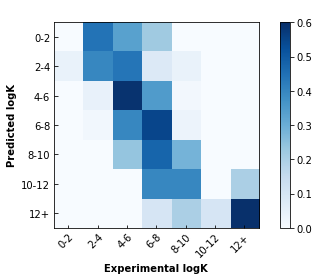

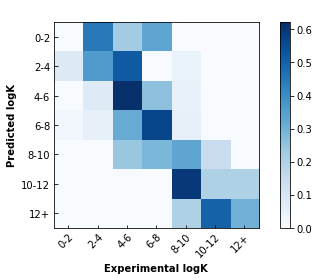

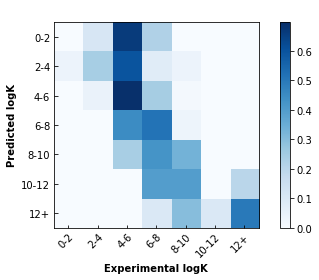

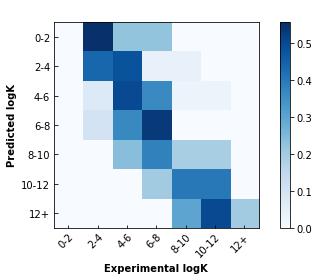

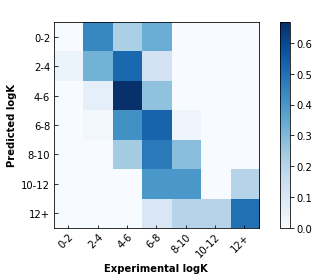

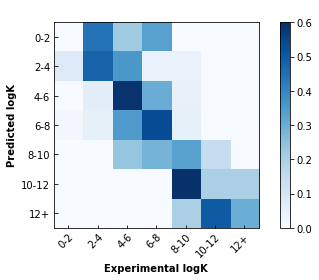

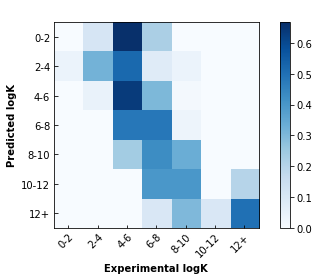

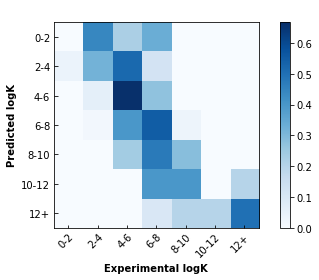

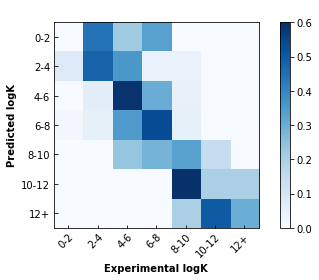

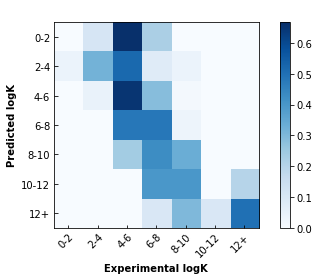

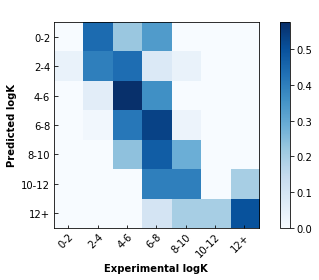

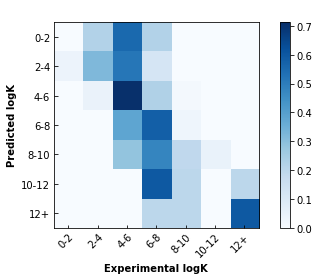

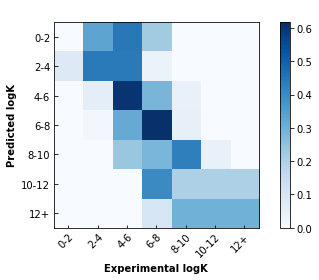

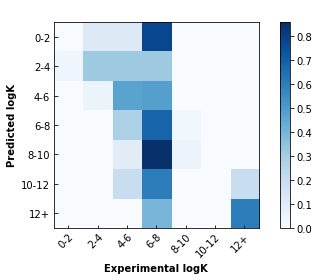

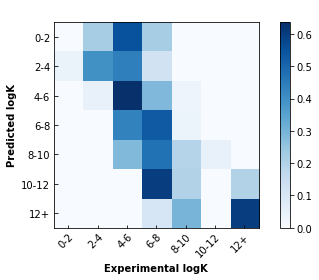

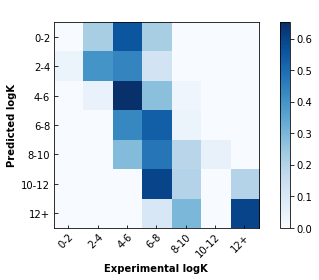

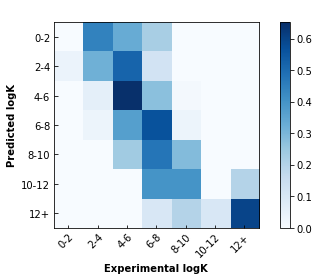

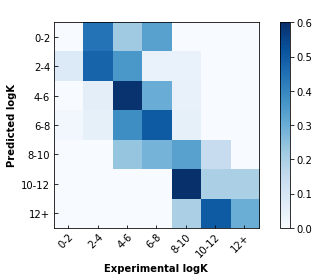

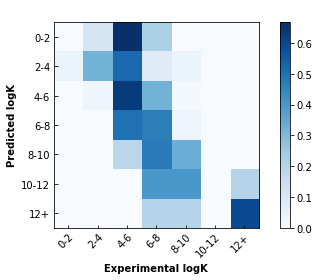

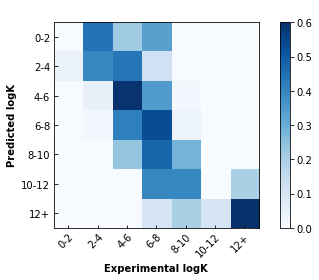

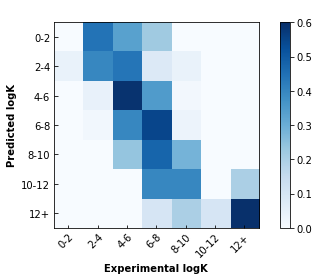

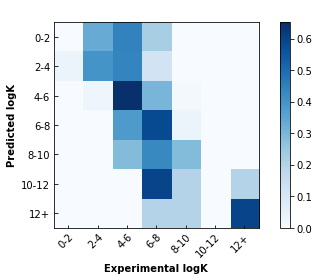

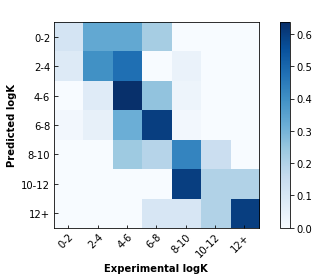

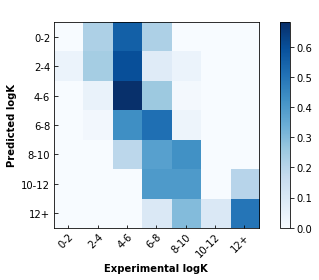

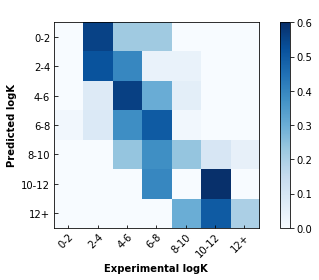

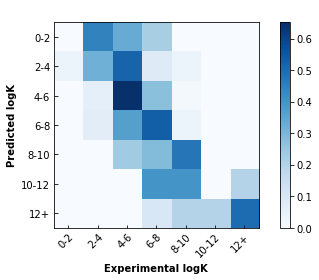

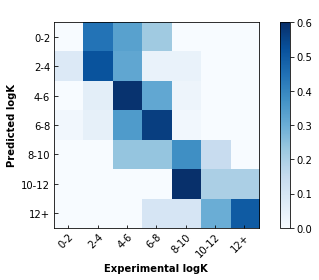

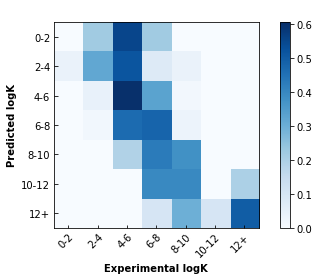

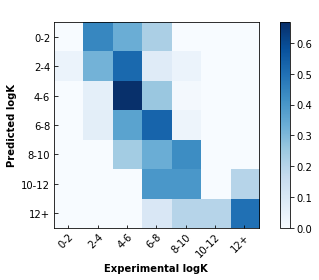

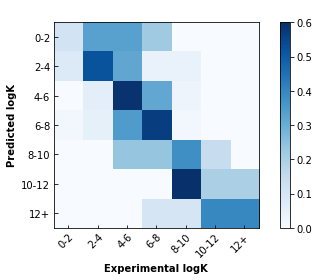

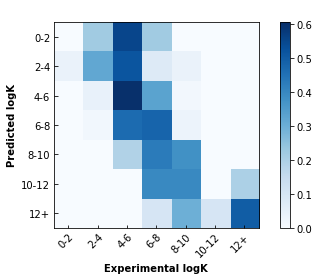

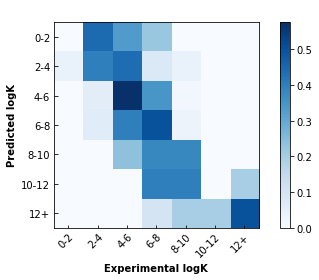

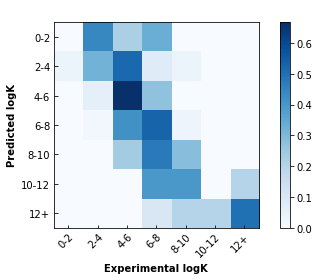

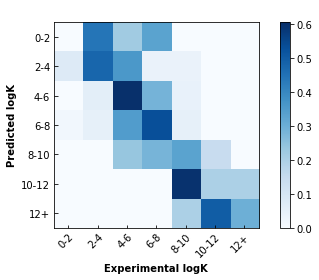

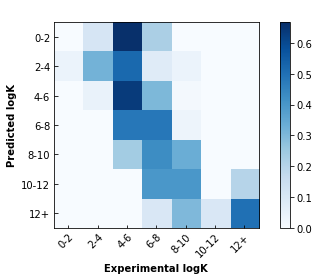

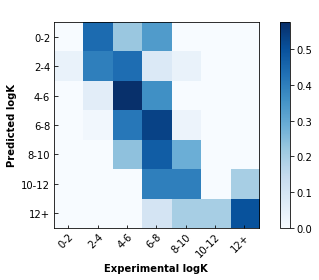

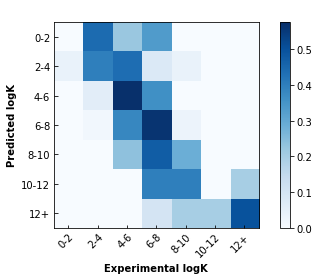

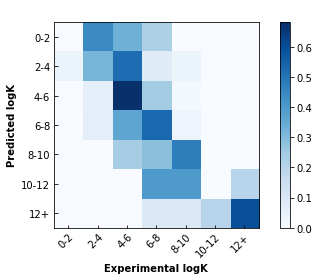

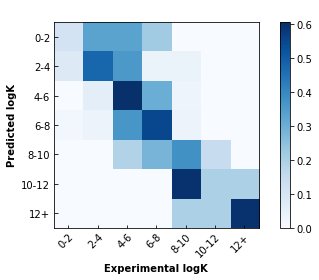

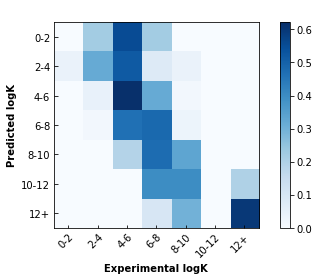

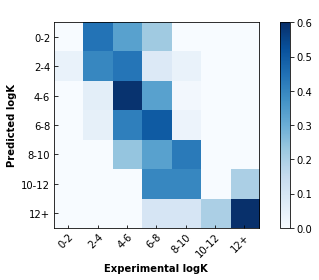

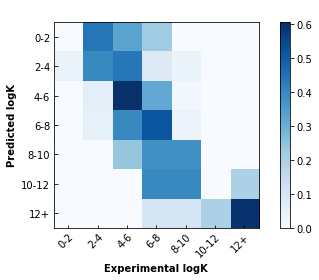

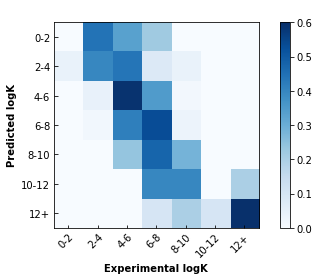

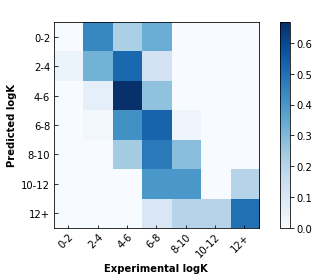

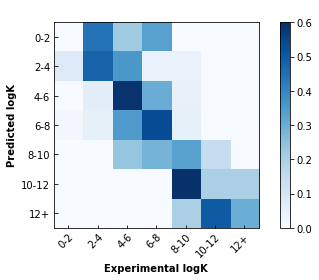

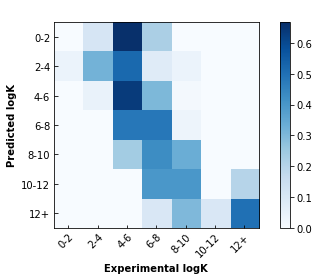

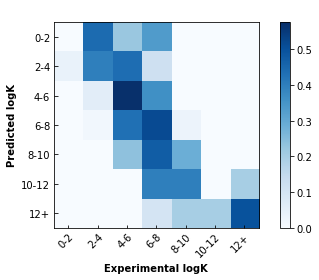

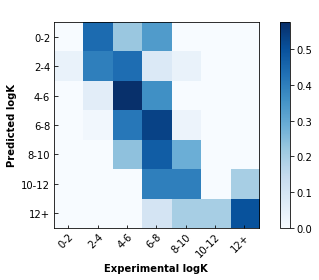

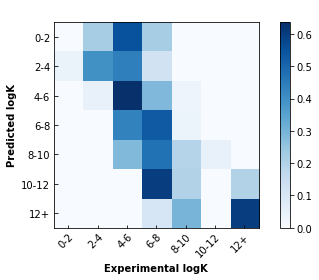

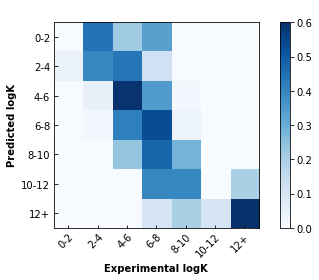

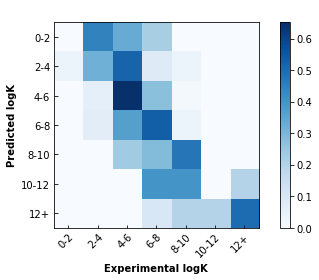

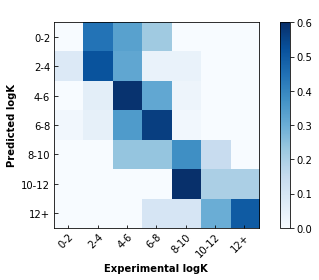

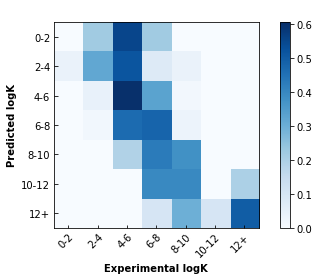

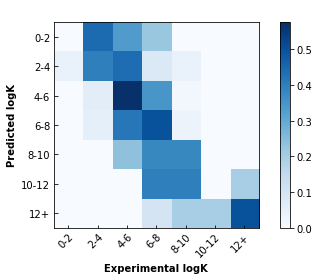

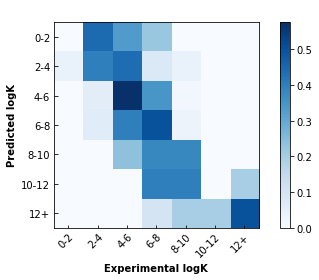

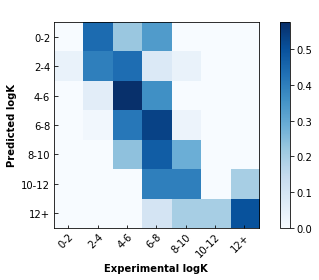

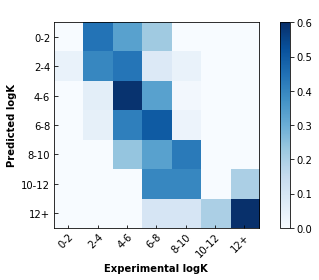

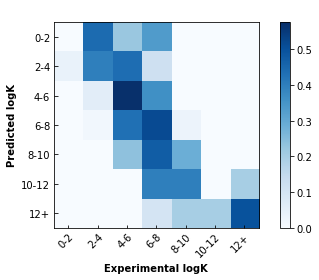

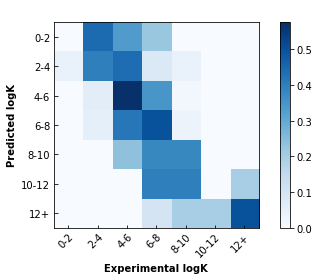

In [18]:
perm_dfs = []
results = []
for t in range(2, len(trains)+1):
    its_train = list(itertools.combinations(trains, t))
    its_test = list(itertools.combinations(tests, t))
    its_alls = list(itertools.combinations(alls, t))
    its_names = list(itertools.combinations(x_names, t))
    for j in range(len(its_train)):
        DD_train = sum(its_train[j])
        DD_test = sum(its_test[j])
        x_names_here = '+'.join(its_names[j])

        results_2 = []
        DD = sum(its_alls[j])
        for i in range(X1.shape[0]):
            y_train_here = np.delete(y, i, 0)
            y_test_here = y[i]
            DD_train_here, DD_test_here = remove_for_loo(DD, i)

            clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)

            clf.fit(DD_train_here,y_train_here)
            prediction = clf.predict(DD_test_here)
            results_2.append({'predicted':prediction[0], 'actual':y_test_here, 'key':keys[i]})
        
        graph_res = pd.DataFrame(results_2)
        class_boundaries = create_class_boundaries(graph_res, class_limits)
        plot_confusion_matrix(class_boundaries['actual_class'], class_boundaries['predicted_class'], classes=class_names, normalize=True,
                      title=' ')
        plt.savefig('../data/results/both/confusion/{}.png'.format(x_names_here), format='png', dpi=300)
        

In [ ]:
# class_limits = [2, 4, 6, 8, 10, 12]
# class_names = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12+']

In [10]:
classes = create_classes(y, class_limits)

In [11]:
classes[0].unique()

array([2, 3, 1, 4, 7, 5, 0])

In [12]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [13]:
y = label_binarize(classes, classes=classes[0].unique())
n_classes = y.shape[1]

In [14]:
x_names = ['1', '2', '3', '4', '5', '6', '7', '8']

In [16]:
perm_dfs = []
results = []

for t in range(2, len(trains)+1):
    its_train = list(itertools.combinations(trains, t))
    its_test = list(itertools.combinations(tests, t))
    its_alls = list(itertools.combinations(alls, t))
    its_names = list(itertools.combinations(x_names, t))
    for j in range(len(its_train)):
        x_names_here = ', '.join(its_names[j])
        
        DD = sum(its_alls[j])
        
#         X_train, X_test, y_train, y_test = train_test_split(DD, y, random_state=0, test_size=0.1)
        X_train, X_test = DD[42:, 42:], DD[:42, 42:]
        y_train, y_test = y[42:], y[:42]
        clf = OneVsRestClassifier(svm.SVC(kernel='precomputed', C=10, probability=True))
        y_score = clf.fit(X_train,y_train).decision_function(X_test)
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
#         plt.figure()
#         lw = 2
#         plt.plot(fpr[2], tpr[2], color='darkorange',
#                  lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
#         plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver operating characteristic example')
#         plt.legend(loc="lower right")
#         plt.show()
        
        lw = 2

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            inter = interp(all_fpr, fpr[i], tpr[i])
            if not np.isnan(inter).any():
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])
                
        # Finally average it and compute AUC
        mean_tpr /= (n_classes-1)
    
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='Micro ({0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='Macro ({0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['#D8E0BB', '#B6CEC7', '#86A3C3', '#7268A6', '#6B3074', '#86808C'])
        for i, color in zip(range(n_classes), colors):
            if not np.isnan(roc_auc[i]):
                plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                         label='{0} ({1:0.2f})'
                         ''.format(class_names[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontweight='bold')
        plt.ylabel('True Positive Rate', fontweight='bold')
        plt.tick_params(direction='in')
        plt.title('{}'.format(x_names_here))

#         ax = plt.subplot(111)
        plt.legend(loc="lower right")
#         box = ax.get_position()
#         ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#         # Put a legend to the right of the current axis
#         ax.legend(loc='center right', bbox_to_anchor=(1, 0.5))
        plt.savefig('../data/results/both/roc_auc/{}.png'.format(x_names_here), format='png', dpi=300)
        plt.close()

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr

/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetr